# Описание гипотезы
### Проверим предположения
1. Определить, насколько обучение сокращает время прохождения этапов игры.
2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3. Проверить, насколько прозрачен процесс взаимодействия с игрой.
#### Проверять будем на данных пользователей, зарегистрированных в 2018 году (1 января 2018 - 31 декабря 2018)

Импротируем нужные библиотеки

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Загружаем данные

In [18]:
events_df = pd.read_csv('data/7_4_Events.csv', sep=',')
purchase_df = pd.read_csv('data/purchase.csv', sep=',')

## Производим предобработку данных

Выделяем пользователей зарегистрирванных в 2018 году и загружаем данные по ним в отдельные датафреймы

In [19]:
# Создаем фильтр по пользователям, зарегистрировавшихся в 2018 году
mask = (events_df['start_time'] >= '2018-01-01') & (events_df['start_time'] < '2019-01-01') & (events_df['event_type'] == 'registration')

regist_2018 = events_df[mask]['user_id'].to_list() # список пользователей зарегистрировавшихся в 2018 году 

events_2018 = events_df[events_df['user_id'].isin(regist_2018)].copy() # отбираем все записи с этими пользователями в таблице events
purchase_2018 = purchase_df[purchase_df['user_id'].isin(regist_2018)].copy() # отбираем все записи с этими пользователями в таблице purchase


Преобразуем даты в полученых датафреймах

In [20]:
purchase_2018['event_datetime'] = pd.to_datetime(purchase_2018['event_datetime'])
events_2018['start_time'] = pd.to_datetime(events_2018['start_time'])

Перед объединением датафреймов, переименуем колонки идентификаторов

In [21]:
events_2018 = events_2018.rename(columns={'id':'event_id'})
purchase_2018 = purchase_2018.rename(columns={'id':'purchase_id'})
purchase_2018['start_time'] = purchase_2018['event_datetime']
purchase_2018['event_type'] = 'purchase'

Сделаем объединенный датафрейм из событий и оплат

In [22]:
total_events_df = pd.concat([events_2018,purchase_2018],sort=False)
total_events_df = total_events_df.reset_index(drop=True).sort_values('start_time')

### Проверим 1-ю гипотезу
* Насколько обучение сокращает время прохождения этапов игры

Сформируем группы пользователей, которые проходили обучение и которые не проходили

In [23]:
# Пользователи которые прошли обучение
users_tutorial_finish = total_events_df[total_events_df['event_type'] == 'tutorial_finish']['user_id'].unique()
print('Количество пользователей завершивших обучение: {}'.format(len(users_tutorial_finish)))
# Пользователи которые не проходили обучение
users_not_tutorial = total_events_df[~(total_events_df['user_id'].isin(users_tutorial_finish))]['user_id'].unique()
print('Количество пользователей не проходивших обучение: {}'.format(len(users_not_tutorial)))

Количество пользователей завершивших обучение: 10250
Количество пользователей не проходивших обучение: 9676


Разобьем пользователей на группы

In [30]:
#total_events_df['groups'] = total_events_df.apply(lambda x: 'С обучением' if x['user_id'] in users_tutorial_finish else 'Без обучения', axis=1)
total_events_df['groups'] = total_events_df.apply(lambda x: 1 if x['user_id'] in users_tutorial_finish else 0, axis=1)

Сформируем сводную таблицу прохождения этапов игры

In [ ]:
# оставляем только интерисующие нас эвенты
#users_etap = total_events_df[(total_events_df['event_type'] == 'pack_choice') | (total_events_df['event_type'] == 'registration')]

In [31]:
users_etap = total_events_df.pivot_table(
    values='start_time',
    index=['user_id','groups'],
    columns='event_type',
    aggfunc='min'
)

Вычислим разницу во времени прохождения этапов игры

In [32]:
users_etap['level_diff'] = users_etap['level_choice'] - users_etap['registration']
users_etap['pack_diff'] = users_etap['pack_choice'] - users_etap['level_choice']
users_etap['purchase_diff'] = users_etap['purchase'] - users_etap['pack_choice']
#users_etap['time_diff'] = (users_etap['level_diff'] + users_etap['pack_diff'] + users_etap['purchase_diff']).mean()

Вычислим среднее время прохождения по группам

In [33]:
group_avg = users_etap.groupby(by='groups')[['level_diff','pack_diff','purchase_diff']].mean()

In [34]:
group_avg['time_diff'] = group_avg['level_diff'] + group_avg['pack_diff'] + group_avg['purchase_diff']
group_avg

event_type,level_diff,pack_diff,purchase_diff,time_diff
groups,,,,
0,0 days 07:52:17.178359096,0 days 00:05:07.739750445,3 days 22:20:10.483660130,4 days 06:17:35.401769671
1,0 days 07:05:36.854819357,0 days 00:05:18.146058732,3 days 17:17:59.641326883,4 days 00:28:54.642204972


Строим график

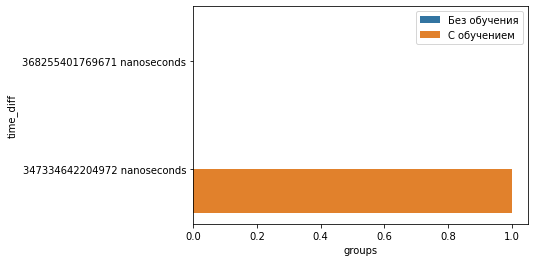

In [36]:
x1 = np.array(['Без обучения','С обучением'])
fig_tg = sns.barplot(
    x=group_avg.index,
    y='time_diff',
    data=group_avg,
    hue=x1
)
plt.show()

### Вывод:
Прохождение обучения положительно сказывается на времени прохождения этапов игры.

* Среднее время прохождения этапов игры у игроков без обучение 4 дня 6 часов 17 минут.
* Среднее время прохождения этапов игры у игроков прошедших обучение 4 дня 28 минут, что на почти 6 часов меньше!

***

### Проверим 2-ю гипотезу
* Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.

Проверим количество игроков сделавших покупку, которые прошли обучение и которые не проходили обучение

In [ ]:
purchase_count_df = total_events_df[total_events_df['event_type']=='purchase'].groupby(by=['groups'])['user_id'].count()
purchase_amount_df = total_events_df[total_events_df['event_type']=='purchase'].groupby(by=['groups'])['amount'].sum()

Выводим график по количеству пользователей сделавших оплату и суммам оплат

In [ ]:
# Кол-во пользователей
fig1 = px.pie(
    data_frame=purchase_count_df,
    values='user_id',
    names=purchase_count_df.index,
    height=500,
    width=500,
    title='Количество пользователей оплативших игру',
    labels={'user_id':'Количество пользователей', 'groups':'Группа'}
    )
# Суммы оплат
fig2 = px.pie(
    data_frame=purchase_amount_df,
    values='amount',
    names=purchase_amount_df.index,
    height=500,
    width=500,
    title='Сумма оплат',
    labels={'amount':'Сумма', 'groups':'Группа'}
    )
#fig.update_traces(hoverinfo='label+percent', textinfo='value')
fig1.update_traces(textposition='inside', textinfo='percent+value')
fig2.update_traces(textposition='inside', textinfo='percent+value')

fig1.show()
fig2.show()


### Вывод
#### Количество пользователей сделавших оплату примерно в 10 раз больше, среди пользователей прошедших обучение. Примерно такое же соотношение в суммах сделаных оплат.
Из этого следует, что само по себе обучение влияет на последующую оплату и уже совершенно не важно каким этапом оно шло

***
### Проверим 3-ю гипотезу
* Проверить, насколько прозрачен процесс взаимодействия с игрой.

Выводим график 

Выведим график

In [ ]:
fig = px.bar(
    data_frame=purchase_count_df,
    x=purchase_count_df.index,
    y='user_id',
    color='user_id',
    orientation='v',
    height=500,
    width=500,
    title='Количество пользователей оплативших игру',
    labels={'user_id':'Количество пользователей', 'groups':'Группы'},
)
fig.show()

### Вывод по гипотезе №1
* 

In [ ]:
total_events_df

In [ ]:
group_avg

In [ ]:
groups_df

In [ ]:
group_avg.columns

In [ ]:
level_choise_total